In [ ]:
import sys
module_path = r"../src"
sys.oath.append(module_path)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

In [ ]:
# read data
df = pd.read_csv('path/to/spreadsheet.csv', low_memory=False)
df_tr = df.query("Group_wearable == 'train'").copy()
df_tr.head()

# Dual - at the same time

In [4]:
# TODO - enforcing a 99.5 % specificity at higher dREMs we begin to lack control data - and the threshold begins to be very unrealiable.
# if we were to bootstrap it, the threshold would vary a lot. How do we account for this?

df_tr.loc[(df_tr['Dx'] == 'control'), 'five_n1w_to_two_r'].value_counts()

five_n1w_to_two_r
0.0     7818
1.0     1755
2.0      606
3.0      210
4.0       84
5.0       28
6.0       10
7.0        6
9.0        4
8.0        2
11.0       2
10.0       1
Name: count, dtype: int64

In [ ]:
from evaluation.threshold_tuning import tune_threshold
from utils import metrics_dict_array

# metrics 
# metric_dict = {
#     'metric': 'f1_score',
#     'display': 'F1 Score',
#     'save_friendly': 'F1_Score',
#     'tuning_fun': None,
# }
# metric_dict = {
#     'metric': '',
#     'display': f'Recall (min Spe=98.%)',
#     'save_friendly': 'maxRe-Sp98',
#     'tuning_fun': metrics_dict_array['recall_min_spe_wrapper'](minimum_specificity=0.98),
# }
metric_dict = {
    'metric': '',
    'display': f'Recall (Spe=99.5%)',
    'save_friendly': 'Re-Sp995',
    'tuning_fun': metrics_dict_array['recall_min_spe_wrapper'](minimum_specificity=0.995),
}

# --- Feature and Metric Configuration ---
feature_outer = {
    'feature': 'five_n1w_to_two_r',
    'display': 'direct REM (Christensen et al. 2015)',
    'plot_type': 'histogram',
    'bigger_than': True,
    'tuning': True,
    'ylim': (0, 4)
}
feature_inner = {
    'feature': 'rem_latency',
    'display': 'REM Latency (min)',
    'plot_type': 'violin',
    'bigger_than': False,
    'tuning': True,
    'ylim': (0, 60),
    'stepsize': 1,
}

# outer feature threshold
best = []
results = []
# source = 'pkl'

for thr_outer in np.arange(feature_outer['ylim'][0], feature_outer['ylim'][1]): 
    
    # Prepare inputs for tuning
    y_true = df_tr['Dx_idx'].copy().values
    y_scores = df_tr[feature_inner['feature']].copy().values
    
    # D-REM < thr_outer --> set REM latency to a million 
    outer_mask = (df_tr[feature_outer['feature']] < thr_outer).values
    y_scores[outer_mask] = 1e6

    # Tune threshold
    tr_thr_best, tr_thr, tr_perf = tune_threshold(
        y_true,
        y_scores,
        bigger_than=feature_inner['bigger_than'],
        metric=metric_dict['metric'],
        tuning_fun=metric_dict['tuning_fun'],
        threshold_maximum=int(feature_inner['ylim'][1]),
        threshold_minimum=max(0, int(feature_inner['ylim'][0])),
        threshold_stepsize=feature_inner['stepsize'],
        max_strategy='max'
    )

    for thr_inner, perf in zip(tr_thr, tr_perf):
        results.append({
            'metric': metric_dict['display'],
            feature_outer['display']: thr_outer,
            feature_inner['display']: thr_inner,
            'performance': perf
        })

    # Set threshold to a million if it goes above threshold
    tr_thr_best['threshold'] = 1e6 if tr_thr_best['threshold'] == feature_inner['ylim'][1] else tr_thr_best['threshold']

    # save best performance
    best.append({
       'metric': metric_dict['display'],
       feature_outer['display']: thr_outer, 
       **tr_thr_best
    }) 

    # apply threshold
    # df[f"p-bin_{feature_outer['feature']}={thr_outer}"] = df.apply(lambda x: (x[feature_outer['feature']] >= thr_outer) & (x[feature_inner['feature']] < tr_thr_best['threshold']), axis=1)
    df[f"p-bin_{feature_outer['feature']}={thr_outer}"] = (df[feature_outer['feature']] >= thr_outer) & (df[feature_inner['feature']] < tr_thr_best['threshold'])

df_bests = pd.DataFrame(best)
df_metrics = pd.DataFrame(results)
df_metrics.info()
# df_metrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   metric                                244 non-null    object 
 1   direct REM (Christensen et al. 2015)  244 non-null    int64  
 2   REM Latency (min)                     244 non-null    int64  
 3   performance                           244 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 7.8+ KB


In [24]:
df_bests.head(10)

,metric,direct REM (Christensen et al. 2015),threshold,index,performance
0,Recall (Spe=99.5%),0,1,1,0.131313
1,Recall (Spe=99.5%),1,7,7,0.303030
2,Recall (Spe=99.5%),2,22,22,0.262626
3,Recall (Spe=99.5%),3,40,40,0.171717


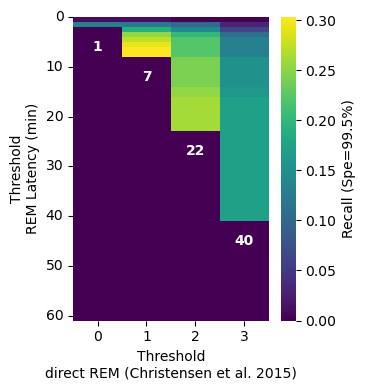

In [ ]:
from matplotlib.ticker import MaxNLocator

# Ensure consistent naming
outer_label = feature_outer['display']
inner_label = feature_inner['display']

plot_best = False
plot_all_outer = False

# ax = axes[c]
fig, ax = plt.subplots(1, 1, figsize=(3.7, 4))

# Pivot for heatmap: rows = inner threshold, cols = outer threshold
surface = df_metrics.pivot(index=inner_label, columns=outer_label, values='performance')

# plot heatmap
sns.heatmap(surface, cmap='viridis', vmin=0, vmax=df_bests['performance'].max(), cbar_kws={'label': 'Performance'}, ax=ax, annot_kws={"size": 8})

# Titles and labels
ax.collections[0].colorbar.set_label(metric_dict['display'])
ax.set_xlabel(f"Threshold\n{feature_outer['display']}")
ax.set_ylabel(f"Threshold\n{feature_inner['display']}")

# Extract actual y-tick values from surface.index
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))  # Adjust nbins as needed

# Limit y-axis (inner threshold) ticks to avoid overcrowding
y_tick_vals = surface.index.to_numpy()

# Show every Nth tick (e.g., every 5th label)
step = max(1, len(y_tick_vals) // 6)  # adjust "6" to control density
ax.set_yticks(y_tick_vals[::step])
ax.set_yticklabels([str(y) for y in y_tick_vals[::step]])

for i, row in df_bests.iterrows():
    df_best = row.to_dict()

    best_outer = int(df_best[outer_label])
    best_inner = int(df_best['threshold'])
    best_perf = float(df_best['performance'])

    try:
        x_loc = surface.columns.get_loc(best_outer) + 0.5
        y_loc = surface.index.get_loc(best_inner) + 5
        
        # Plot the best performance point
        #ax.axhline(
        #    y=y_loc, color=(1.0000, 0.4980, 0.0549), linestyle='-', linewidth=1.5, label='Best Inner Threshold'
        #)
        #ax.axvline(
        #    x=x_loc, color=(1.0000, 0.4980, 0.0549), linestyle='-', linewidth=1.5, label='Best Outer Threshold'
        #)

        ax.text(
            x=x_loc,
            y=y_loc,
            #s=f"{best_perf:.2f}",
            s=f"{best_inner}",
            color='white', # if best_perf < 0.40 else 'black',
            ha='center', va='center',
            fontsize=10,
            fontweight='bold',
            # bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.3')
        )
    except:
        k = 1

plt.tight_layout()
plt.show()
